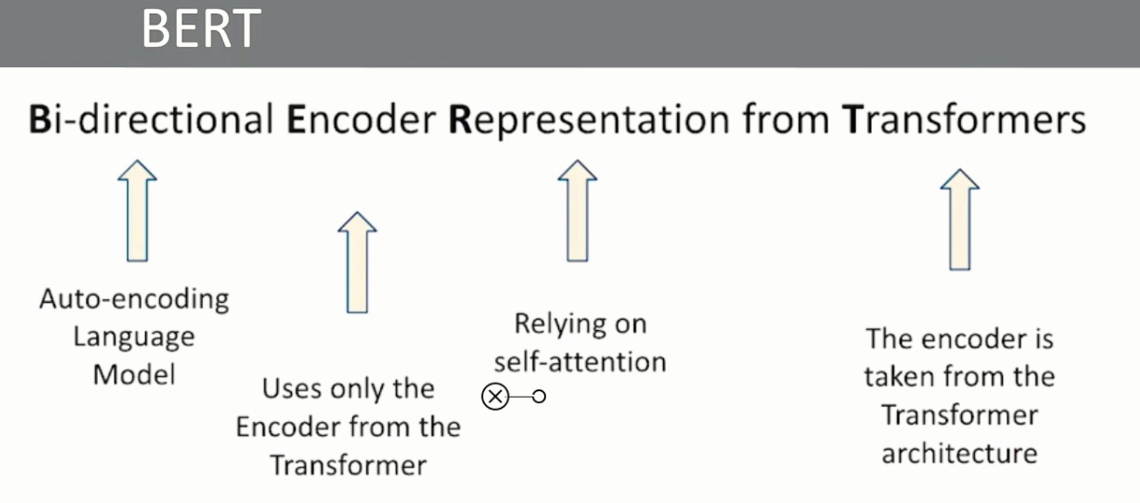

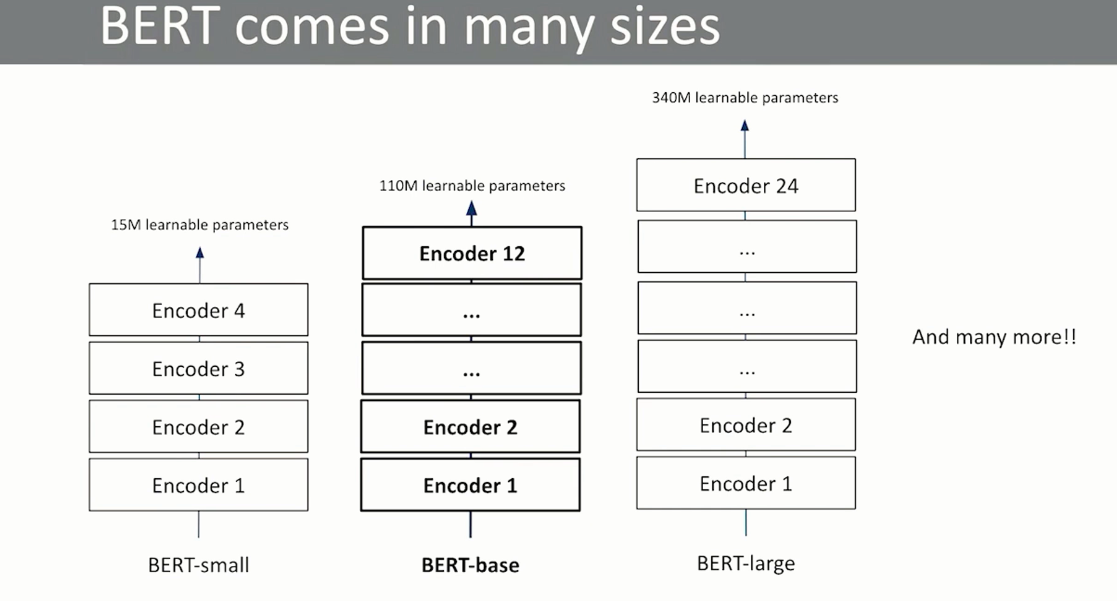

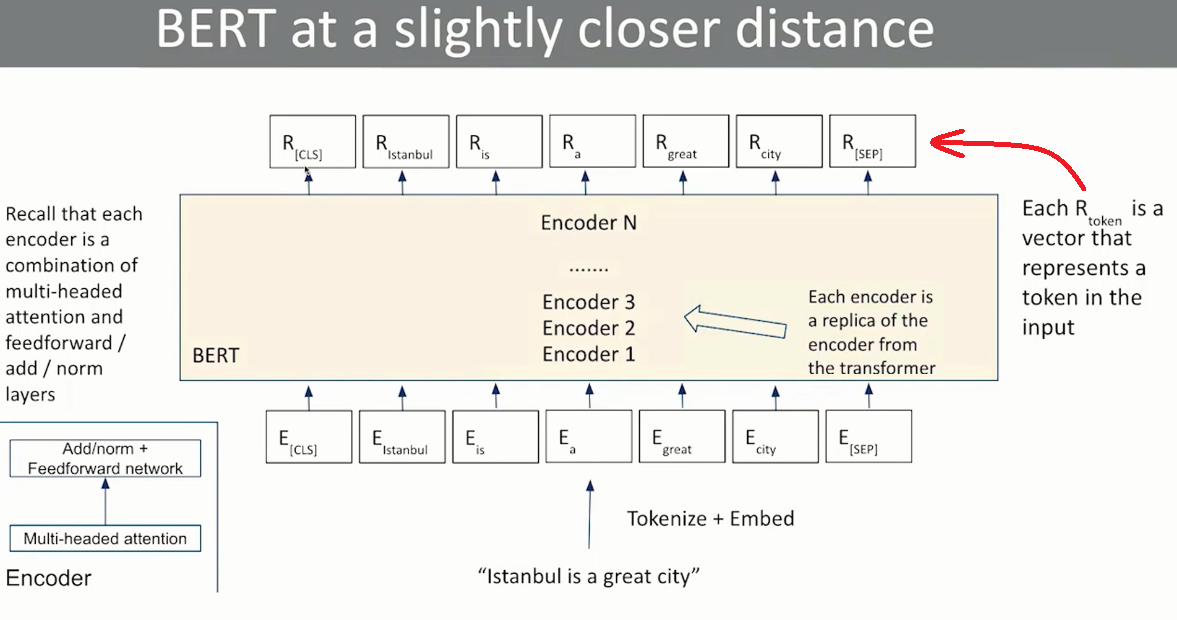

## Introduction to BERT

In [1]:
from transformers import BertTokenizer, BertModel
import torch
from sklearn.metrics.pairwise import cosine_similarity

In [2]:
# Let's load a vanilla BERT-base model. 
model = BertModel.from_pretrained('bert-base-uncased')

In [3]:
# Get all of the model's parameters as a list of tuples.
named_params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(named_params)))

print('==== Embedding Layer ====\n')
for p in named_params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Encoder ====\n')
for p in named_params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')
for p in named_params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))


The BERT model has 199 different named parameters.

==== Embedding Layer ====

embeddings.word_embeddings.weight                       (30522, 768)
embeddings.position_embeddings.weight                     (512, 768)
embeddings.token_type_embeddings.weight                     (2, 768)
embeddings.LayerNorm.weight                                   (768,)
embeddings.LayerNorm.bias                                     (768,)

==== First Encoder ====

encoder.layer.0.attention.self.query.weight               (768, 768)
encoder.layer.0.attention.self.query.bias                     (768,)
encoder.layer.0.attention.self.key.weight                 (768, 768)
encoder.layer.0.attention.self.key.bias                       (768,)
encoder.layer.0.attention.self.value.weight               (768, 768)
encoder.layer.0.attention.self.value.bias                     (768,)
encoder.layer.0.attention.output.dense.weight             (768, 768)
encoder.layer.0.attention.output.dense.bias                   (768,

In [5]:
# The pooler is a separate linear and tanh activated layer that acts on the [CLS] token's representation
# This pooled_output is often used as a representation for the entire sentence.

In [4]:
# load the bert-base uncased tokenizer.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [8]:
tokenizer.encode('Sinan loves a beautiful day')  # tokenize a simple sequence

[101, 8254, 2319, 7459, 1037, 3376, 2154, 102]

In [9]:
# run tokens through the model

#1 Turn tokens_with_unknown_words into a tensor (will be size (8,))
#2 Unsqueeze a first dimension to simulate batches. Resulting shape is (1, 8)
response = model(torch.tensor(tokenizer.encode('Sinan loves a beautiful day')).unsqueeze(0))

In [10]:
response

BaseModelOutputWithPoolingAndCrossAttentions(last_hidden_state=tensor([[[-0.2327,  0.1515, -0.0448,  ..., -0.5192,  0.4195,  0.2948],
         [ 0.3051, -0.6614,  0.2500,  ..., -0.9809,  0.2551,  0.2400],
         [-0.3610, -0.8759,  0.4542,  ..., -1.1120,  0.1791,  0.0664],
         ...,
         [ 0.0689, -0.0364,  0.4940,  ..., -0.6558,  0.2227, -0.3868],
         [-0.2657, -0.4257,  0.0056,  ...,  0.1352,  0.3596, -0.4585],
         [ 0.6100,  0.0263, -0.2532,  ..., -0.0680, -0.3901, -0.3541]]],
       grad_fn=<NativeLayerNormBackward0>), pooler_output=tensor([[-0.8777, -0.4542, -0.6287,  0.7511,  0.3151, -0.0913,  0.9175,  0.3766,
         -0.3059, -1.0000, -0.0577,  0.7535,  0.9913,  0.2113,  0.9418, -0.5328,
         -0.0568, -0.5698,  0.4090, -0.6096,  0.7876,  0.9995,  0.3670,  0.2453,
          0.4620,  0.9465, -0.6802,  0.9342,  0.9614,  0.7060, -0.5755,  0.2076,
         -0.9910, -0.1697, -0.8019, -0.9952,  0.3786, -0.7309, -0.0599, -0.0186,
         -0.8722,  0.3377,  0.99

In [11]:
# Embedding for each token, the first one being the [CLS] token
response.last_hidden_state

tensor([[[-0.2327,  0.1515, -0.0448,  ..., -0.5192,  0.4195,  0.2948],
         [ 0.3051, -0.6614,  0.2500,  ..., -0.9809,  0.2551,  0.2400],
         [-0.3610, -0.8759,  0.4542,  ..., -1.1120,  0.1791,  0.0664],
         ...,
         [ 0.0689, -0.0364,  0.4940,  ..., -0.6558,  0.2227, -0.3868],
         [-0.2657, -0.4257,  0.0056,  ...,  0.1352,  0.3596, -0.4585],
         [ 0.6100,  0.0263, -0.2532,  ..., -0.0680, -0.3901, -0.3541]]],
       grad_fn=<NativeLayerNormBackward0>)

In [12]:
# This layer is trained on top of the Embedding of the CLS token

response.pooler_output.shape

torch.Size([1, 768])

In [13]:
model.pooler

BertPooler(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (activation): Tanh()
)

In [14]:
# grab the final encoder's representation of the CLS token
CLS_embedding = response.last_hidden_state[:, 0, :].unsqueeze(0)

CLS_embedding.shape

torch.Size([1, 1, 768])

In [15]:
model.pooler(CLS_embedding).shape

torch.Size([1, 768])

In [16]:
# Running the embedding for CLS through the pooler gives the same output as the "pooler_output"
(model.pooler(CLS_embedding) == response.pooler_output).all()

tensor(True)

In [17]:
total_params = 0
for p in model.parameters():
    if len(p.shape) == 2:
        total_params += p.shape[0] * p.shape[1]
        
print(f'Total Parameters: {total_params:,}')  # This is where the 110M parameter comes from

Total Parameters: 109,360,128


# Wordpiece Tokenization

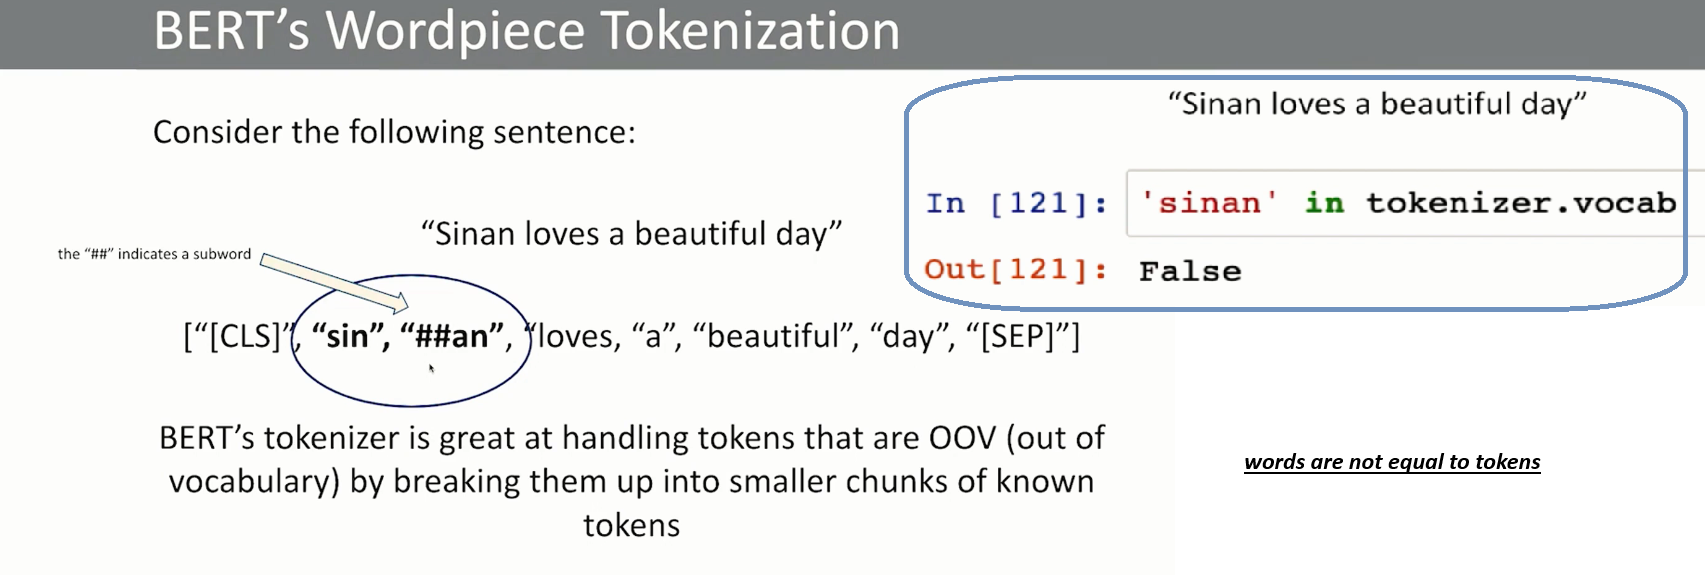

## Let's start by taking a look at the Bert Tokenizer.

Let's use the `from_pretrained` method to grab the uncased bert-base tokenizer

A list of all available modules can be found on their site: https://huggingface.co/transformers/pretrained_models.html

In [78]:
from transformers import BertModel, BertTokenizer
import torch
from sklearn.metrics.pairwise import cosine_similarity

In [79]:
# load the bert-base uncased tokenizer. Quick check what does "uncased" mean?
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

print(f'Length of BERT base vocabulary: {len(tokenizer.vocab)}')

Length of BERT base vocabulary: 30522


In [97]:
text = "A simple sentence!"

tokens = tokenizer.encode(text)  # get token ids per BERT-base's vocabulary
print(tokens)

[101, 1037, 3722, 6251, 999, 102]


In [99]:
# decode will re-construct the sentence with the added [CLS] and [SEP] token
tokenizer.decode(tokens)

'[CLS] a simple sentence! [SEP]'

In [82]:
text = "My friend told me about this class and I love it so far! She was right."

tokens = tokenizer.encode(text)
print(tokens)

[101, 2026, 2767, 2409, 2033, 2055, 2023, 2465, 1998, 1045, 2293, 2009, 2061, 2521, 999, 2016, 2001, 2157, 1012, 102]


In [83]:
# A nicer printout  of token ids and token strings

print(f'Text: {text}. Num tokens: {len(tokens)}')
for t in tokens:
    print(f'Token: {t}, subword: {tokenizer.decode([t])}')

Text: My friend told me about this class and I love it so far! She was right.. Num tokens: 20
Token: 101, subword: [CLS]
Token: 2026, subword: my
Token: 2767, subword: friend
Token: 2409, subword: told
Token: 2033, subword: me
Token: 2055, subword: about
Token: 2023, subword: this
Token: 2465, subword: class
Token: 1998, subword: and
Token: 1045, subword: i
Token: 2293, subword: love
Token: 2009, subword: it
Token: 2061, subword: so
Token: 2521, subword: far
Token: 999, subword: !
Token: 2016, subword: she
Token: 2001, subword: was
Token: 2157, subword: right
Token: 1012, subword: .
Token: 102, subword: [SEP]


In [84]:
# Sinan is not in our vocab :'(

'sinan' in tokenizer.vocab

False

In [85]:
text_with_unknown_words = 'Sinan loves a beautiful day'
tokens_with_unknown_words = tokenizer.encode(text_with_unknown_words)

# We see our sub words in action!
for t in tokens_with_unknown_words:
    print(f'Token: {t}, subword: {tokenizer.decode([t])}')

Token: 101, subword: [CLS]
Token: 8254, subword: sin
Token: 2319, subword: ##an
Token: 7459, subword: loves
Token: 1037, subword: a
Token: 3376, subword: beautiful
Token: 2154, subword: day
Token: 102, subword: [SEP]


In [100]:
tokenizer.encode('sinan')

[101, 8254, 2319, 102]

In [101]:
tokenizer.encode('an')

[101, 2019, 102]

In [86]:
text_with_unknown_words = 'Sinan is our instructor for this awesomesauce class'
tokens_with_unknown_words = tokenizer.encode(text_with_unknown_words)

for t in tokens_with_unknown_words:
    print(f'Token: {t}, subword: {tokenizer.decode([t])}')

Token: 101, subword: [CLS]
Token: 8254, subword: sin
Token: 2319, subword: ##an
Token: 2003, subword: is
Token: 2256, subword: our
Token: 9450, subword: instructor
Token: 2005, subword: for
Token: 2023, subword: this
Token: 12476, subword: awesome
Token: 23823, subword: ##sau
Token: 3401, subword: ##ce
Token: 2465, subword: class
Token: 102, subword: [SEP]


In [87]:
text = "My friend told me about this class and I love it so far! She was right."

# encode_plus gives us token ids, attention mask and segment ids (A vs B). Useful for training time
tokens = tokenizer.encode_plus(text)
print(tokens)

{'input_ids': [101, 2026, 2767, 2409, 2033, 2055, 2023, 2465, 1998, 1045, 2293, 2009, 2061, 2521, 999, 2016, 2001, 2157, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [88]:
tokenizer(text)  # calling the tokenizer directly does the same thing as encode_plus

{'input_ids': [101, 2026, 2767, 2409, 2033, 2055, 2023, 2465, 1998, 1045, 2293, 2009, 2061, 2521, 999, 2016, 2001, 2157, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [89]:
# python is the 6th token (don't forget the [CLS] token!)
python_pet = tokenizer.encode('I love my pet python')

# python is the 6th token (don't forget the [CLS] token!)
python_language = tokenizer.encode('I love coding in python')

In [90]:
# contextful embedding of 'python' in 'I love my pet python'
python_pet_embedding = model(torch.tensor(python_pet).unsqueeze(0))[0][:,5,:].detach().numpy()

# contextful embedding of 'python' in 'I love coding in python'
python_language_embedding = model(torch.tensor(python_language).unsqueeze(0))[0][:,5,:].detach().numpy()

# contextful embedding of 'snake' in 'snake'
snake_alone_embedding = model(torch.tensor(tokenizer.encode('snake')).unsqueeze(0))[0][:,1,:].detach().numpy()

# contextful embedding of 'programming' in 'programming'
programming_alone_embedding = model(torch.tensor(tokenizer.encode('programming')).unsqueeze(0))[0][:,1,:].detach().numpy()

In [103]:
python_pet_embedding.shape

(1, 768)

In [104]:
python_language_embedding.shape

(1, 768)

In [91]:
# Similarity of the representation of the word Python in a sentence about coding to the word snake
cosine_similarity(python_language_embedding, snake_alone_embedding)

array([[0.5843483]], dtype=float32)

In [92]:
# Similarity of the representation of the word Python in a sentence about pets to the word snake. More similar!
cosine_similarity(python_pet_embedding, snake_alone_embedding)

array([[0.69286585]], dtype=float32)

In [93]:
# Similarity of the representation of the word Python in a sentence about pets to the word programming
cosine_similarity(python_pet_embedding, programming_alone_embedding)

array([[0.49864468]], dtype=float32)

In [94]:
# Similarity of the representation of the word Python in a sentence about coding to the word programming. More similar!
cosine_similarity(python_language_embedding, programming_alone_embedding)

array([[0.561475]], dtype=float32)

## The many embeddings of BERT

In [24]:
from transformers import BertModel, BertTokenizer

In [25]:
model = BertModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [26]:
"""
word_embeddings == context-free word embeddings
position_embeddings == encodes word position
token_type_embeddings == 0 or 1. Used to lookup the segment embedding
"""

model.embeddings

BertEmbeddings(
  (word_embeddings): Embedding(30522, 768, padding_idx=0)
  (position_embeddings): Embedding(512, 768)
  (token_type_embeddings): Embedding(2, 768)
  (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
  (dropout): Dropout(p=0.1, inplace=False)
)

In [106]:
example_phrase = 'I am Sinan'

# return_tensors='pt' converts to pytorch automatically
tokenizer.encode(example_phrase, return_tensors='pt')

tensor([[ 101, 1045, 2572, 8254, 2319,  102]])

In [29]:
# context-less embedding of each token in our sentence
model.embeddings.word_embeddings(tokenizer.encode(example_phrase, return_tensors='pt'))

tensor([[[ 0.0136, -0.0265, -0.0235,  ...,  0.0087,  0.0071,  0.0151],
         [-0.0211,  0.0059, -0.0179,  ...,  0.0163,  0.0122,  0.0073],
         [-0.0437, -0.0150,  0.0029,  ..., -0.0282,  0.0474, -0.0448],
         [-0.0022, -0.0876,  0.0143,  ...,  0.0232, -0.0024, -0.0213],
         [-0.0614, -0.0044, -0.0755,  ..., -0.0522, -0.0310, -0.0248],
         [-0.0145, -0.0100,  0.0060,  ..., -0.0250,  0.0046, -0.0015]]],
       grad_fn=<EmbeddingBackward0>)

In [30]:
# Note the first and last row are the same because they are the 
#  [CLS] and [SEP] reserved tokens. They are the same without context for every input
model.embeddings.word_embeddings(tokenizer.encode('I am Matt', return_tensors='pt'))

tensor([[[ 0.0136, -0.0265, -0.0235,  ...,  0.0087,  0.0071,  0.0151],
         [-0.0211,  0.0059, -0.0179,  ...,  0.0163,  0.0122,  0.0073],
         [-0.0437, -0.0150,  0.0029,  ..., -0.0282,  0.0474, -0.0448],
         [-0.0381, -0.0026,  0.0130,  ...,  0.0038, -0.0279, -0.0082],
         [-0.0145, -0.0100,  0.0060,  ..., -0.0250,  0.0046, -0.0015]]],
       grad_fn=<EmbeddingBackward0>)

In [32]:
model.embeddings.position_embeddings  # 512 embeddings, one for each position in a max 512 input sequence

Embedding(512, 768)

In [107]:
torch.LongTensor(range(6))

tensor([0, 1, 2, 3, 4, 5])

In [33]:
model.embeddings.position_embeddings(torch.LongTensor(range(6)))  # positional embeddings for our example_phrase

tensor([[ 1.7505e-02, -2.5631e-02, -3.6642e-02,  ...,  3.3437e-05,
          6.8312e-04,  1.5441e-02],
        [ 7.7580e-03,  2.2613e-03, -1.9444e-02,  ...,  2.8910e-02,
          2.9753e-02, -5.3247e-03],
        [-1.1287e-02, -1.9644e-03, -1.1573e-02,  ...,  1.4908e-02,
          1.8741e-02, -7.3140e-03],
        [-4.1949e-03, -1.1852e-02, -2.1180e-02,  ...,  2.2455e-02,
          5.2826e-03, -1.9723e-03],
        [-5.6087e-03, -1.0445e-02, -7.2288e-03,  ...,  2.0837e-02,
          3.5402e-03,  4.7708e-03],
        [-3.0871e-03, -1.8956e-02, -1.8930e-02,  ...,  7.4045e-03,
          2.0183e-02,  3.4077e-03]], grad_fn=<EmbeddingBackward0>)

In [34]:
model.embeddings.token_type_embeddings  # 2 embeddings. One for A and one for B

Embedding(2, 768)

In [108]:
torch.LongTensor([0]*6)

tensor([0, 0, 0, 0, 0, 0])

In [35]:
model.embeddings.token_type_embeddings(torch.LongTensor([0]*6))  # All tokens have the same embedding

tensor([[ 0.0004,  0.0110,  0.0037,  ..., -0.0066, -0.0034, -0.0086],
        [ 0.0004,  0.0110,  0.0037,  ..., -0.0066, -0.0034, -0.0086],
        [ 0.0004,  0.0110,  0.0037,  ..., -0.0066, -0.0034, -0.0086],
        [ 0.0004,  0.0110,  0.0037,  ..., -0.0066, -0.0034, -0.0086],
        [ 0.0004,  0.0110,  0.0037,  ..., -0.0066, -0.0034, -0.0086],
        [ 0.0004,  0.0110,  0.0037,  ..., -0.0066, -0.0034, -0.0086]],
       grad_fn=<EmbeddingBackward0>)

In [36]:
# Apply feed forward normalization layer

model.embeddings.LayerNorm(
    model.embeddings.word_embeddings(tokenizer.encode(example_phrase, return_tensors='pt')) + \
    model.embeddings.position_embeddings(torch.LongTensor(range(6))) + \
    model.embeddings.token_type_embeddings(torch.LongTensor([0]*6))
)

tensor([[[ 1.6855e-01, -2.8577e-01, -3.2613e-01,  ..., -2.7571e-02,
           3.8253e-02,  1.6400e-01],
         [-3.4025e-04,  5.3974e-01, -2.8805e-01,  ...,  7.5731e-01,
           8.9008e-01,  1.6575e-01],
         [-6.3496e-01,  1.9748e-01,  2.5116e-01,  ..., -4.0819e-02,
           1.3468e+00, -6.9357e-01],
         [ 2.8197e-01, -1.0037e+00,  3.5063e-01,  ...,  8.5378e-01,
           3.9389e-01, -8.4527e-02],
         [-7.3509e-01,  3.3429e-01, -8.3037e-01,  ..., -2.1545e-01,
          -6.6517e-02, -2.6881e-02],
         [-3.2507e-01, -3.1879e-01, -1.1632e-01,  ..., -3.9602e-01,
           4.1120e-01, -7.7552e-02]]], grad_fn=<NativeLayerNormBackward0>)

In [37]:
# Et Voilà! The many embeddings of BERT become one embedding per token
model.embeddings(tokenizer.encode(example_phrase, return_tensors='pt'))

tensor([[[ 1.6855e-01, -2.8577e-01, -3.2613e-01,  ..., -2.7571e-02,
           3.8253e-02,  1.6400e-01],
         [-3.4026e-04,  5.3974e-01, -2.8805e-01,  ...,  7.5731e-01,
           8.9008e-01,  1.6575e-01],
         [-6.3496e-01,  1.9748e-01,  2.5116e-01,  ..., -4.0819e-02,
           1.3468e+00, -6.9357e-01],
         [ 2.8197e-01, -1.0037e+00,  3.5063e-01,  ...,  8.5378e-01,
           3.9389e-01, -8.4527e-02],
         [-7.3509e-01,  3.3429e-01, -8.3037e-01,  ..., -2.1545e-01,
          -6.6517e-02, -2.6881e-02],
         [-3.2507e-01, -3.1879e-01, -1.1632e-01,  ..., -3.9602e-01,
           4.1120e-01, -7.7552e-02]]], grad_fn=<NativeLayerNormBackward0>)

In [109]:
model.embeddings(tokenizer.encode(example_phrase, return_tensors='pt')).shape

torch.Size([1, 6, 768])